In [1]:
import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150,facecolor='white')

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/uma

scanpy==1.9.5 anndata==0.10.3 umap==0.5.3 numpy==1.26.1 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.1 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.10


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [88]:
adata = sc.read("PBMC.h5ad")

/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [89]:
signed_mi          = True #or False
init_ortho         = True
adata_h5ad         = "PBMC.h5ad"
embedding_size     = 100
c                  = 100
gain               = 10
vector_file        = "embeddings/pbmc.vec"
retrain            = True
device             = "cpu"

# Process Data

In [90]:
dataset = GeneVectorDataset(adata,load_expression=retrain,signed_mi=signed_mi,device=device)

/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/genevector/data.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type(context.metadata[column][0]) == bytes:


Running...
Loading Expression.
Indexing expression.


100%|██████████| 1051348/1051348 [00:00<00:00, 1739559.26it/s]

Finished.


# Setup Model

In [91]:
cmps = GeneVector(dataset,
                    output_file=vector_file,
                    emb_dimension=embedding_size,
                    c=c,
                    gain=gain,
                    init_ortho=init_ortho,
                    device=device)

*****************
Loading Dataset.
*****************



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6369.68it/s]

Getting gene pairs combinations.


Computing MI for each pair.


100%|██████████| 499500/499500 [00:42<00:00, 11891.87it/s]


...Directional MI....
MI Loaded.
Loading Batches for Training.


100%|██████████| 1000/1000 [00:00<00:00, 1557.29it/s]


Ready to train.


In [103]:
cmps.train(1000)
embed = GeneEmbedding(vector_file, dataset, vector="average")
print(embed.compute_similarities("IFIT1"))

**** Epoch 1520 	Loss: 3092.01037
**** Epoch 1540 	Loss: 3061.81435
**** Epoch 1560 	Loss: 3030.33865
**** Epoch 1580 	Loss: 2999.24104
**** Epoch 1600 	Loss: 2968.60649
**** Epoch 1620 	Loss: 2938.38626
**** Epoch 1640 	Loss: 2908.6057
**** Epoch 1660 	Loss: 2879.20827
**** Epoch 1680 	Loss: 2850.12684
**** Epoch 1700 	Loss: 2821.4594
**** Epoch 1720 	Loss: 2793.13706
**** Epoch 1740 	Loss: 2765.13358
**** Epoch 1760 	Loss: 2737.40298
**** Epoch 1780 	Loss: 2710.05474
**** Epoch 1800 	Loss: 2683.03797
**** Epoch 1820 	Loss: 2656.4624
**** Epoch 1840 	Loss: 2630.26497
**** Epoch 1860 	Loss: 2604.40967
**** Epoch 1880 	Loss: 2578.89073
**** Epoch 1900 	Loss: 2553.71531
**** Epoch 1920 	Loss: 2528.90052
**** Epoch 1940 	Loss: 2504.34443
**** Epoch 1960 	Loss: 2480.16538
**** Epoch 1980 	Loss: 2456.28786
**** Epoch 2000 	Loss: 2432.76373
**** Epoch 2020 	Loss: 2409.52952
**** Epoch 2040 	Loss: 2386.61165
**** Epoch 2060 	Loss: 2364.06853
**** Epoch 2080 	Loss: 2341.88228
**** Epoch 2100 	

100%|██████████| 1000/1000 [00:00<00:00, 3002365.07it/s]

              Gene  Similarity
0            IFIT1    1.000000
1          TNFSF10    0.983455
2            IFIT3    0.970317
3            IFIT2    0.912845
4           CXCL10    0.886478
..             ...         ...
995      ITPKB-AS1   -0.331939
996       CCDC102B   -0.348770
997         ZNF529   -0.454552
998  RP11-819C21.1   -0.470150
999          WNT7A   -0.709956

[1000 rows x 2 columns]


# Compute Similar Genes to IFIT1

In [104]:
embed.compute_similarities("IFIT1")

,Gene,Similarity
0,IFIT1,1.000000
1,TNFSF10,0.983455
2,IFIT3,0.970317
3,IFIT2,0.912845
4,CXCL10,0.886478
...,...,...
995,ITPKB-AS1,-0.331939
996,CCDC102B,-0.348770
997,ZNF529,-0.454552
998,RP11-819C21.1,-0.470150


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/genevector/embedding.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df,y="Gene",x="Similarity",palette="magma_r",ax=ax)


<Axes: title={'center': 'IFIT1 Similarity'}, xlabel='Similarity', ylabel='Gene'>

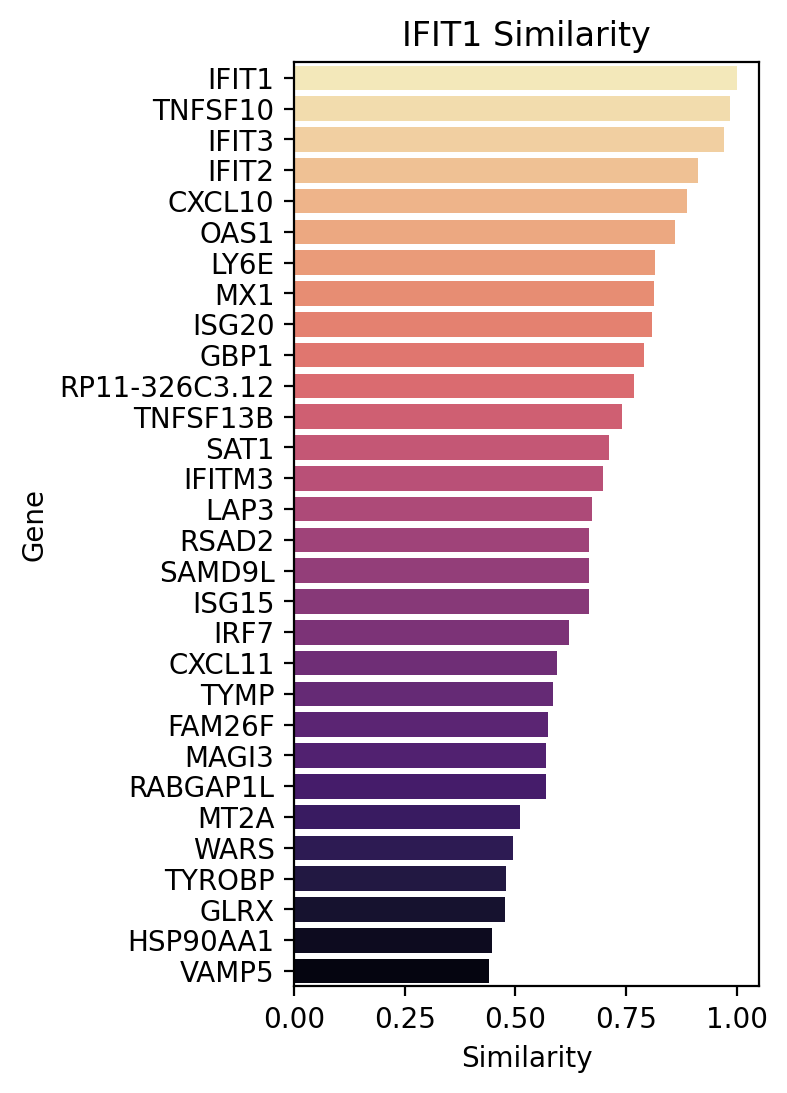

In [105]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
embed.plot_similarities("IFIT1",n_genes=30)

# Build Cell Embedding

normalizing counts per cell
    finished (0:00:00)


100%|██████████| 1051348/1051348 [00:01<00:00, 547855.31it/s]


Generating Cell Vectors.


100%|██████████| 14039/14039 [00:00<00:00, 23359.56it/s]


Found 0 Cells with No Counts.
Finished.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.
computing neighbors


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/genevector/embedding.py:871: ImplicitModificationWarning: Setting element `.obsm['X_genevector']` of view, initializing view as actual.
  adata.obsm['X_genevector'] = numpy.array(x_genevector)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterpl

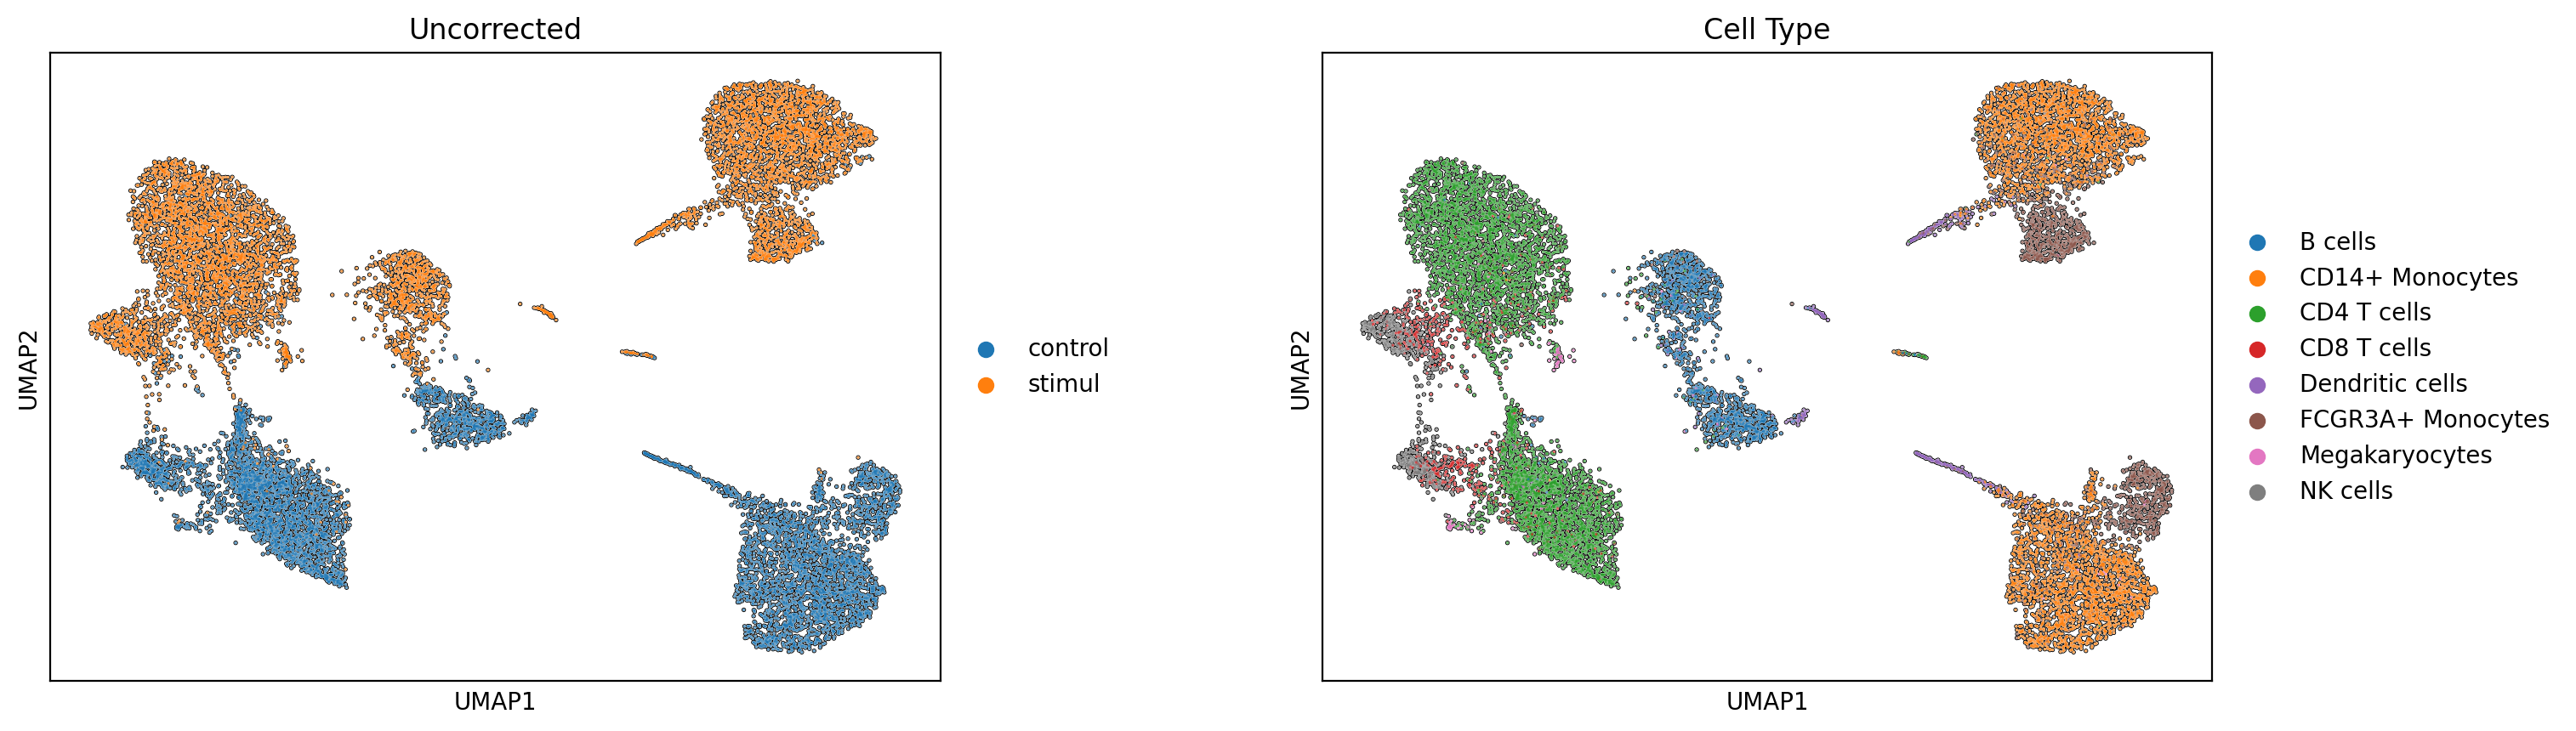

In [106]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
sc.pl.umap(adata,color=["sample","celltype"], wspace=0.3,
                 title=["Uncorrected","Cell Type"],add_outline=True,size=5)

# Apply Batch Correction

Generating batch vectors.
Computing correction vector for stimul.
Applying correction vectors.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.
computing neighbors


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/genevector/embedding.py:871: ImplicitModificationWarning: Setting element `.obsm['X_genevector']` of view, initializing view as actual.
  adata.obsm['X_genevector'] = numpy.array(x_genevector)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterpl

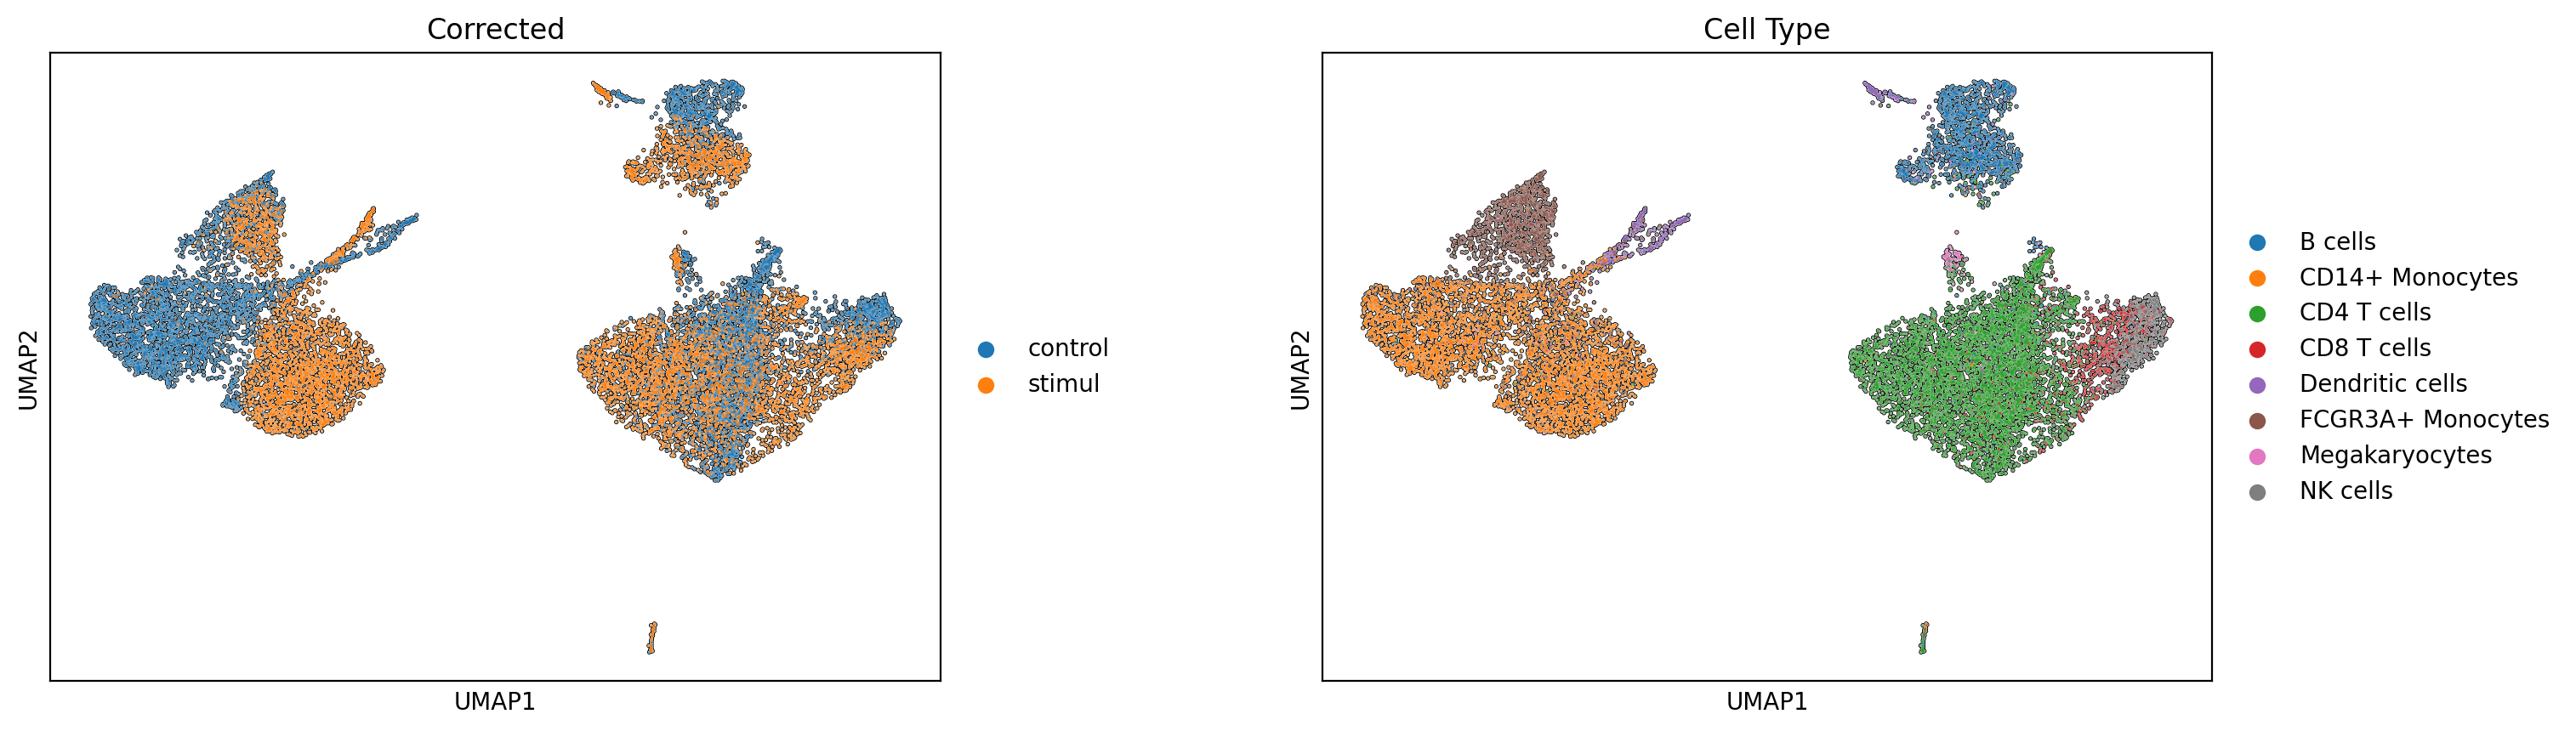

In [107]:
cembed.batch_correct(column="sample",reference="control")
adata = cembed.get_adata()
sc.pl.umap(adata,color=["sample","celltype"], wspace=0.3,
                 title=["Corrected","Cell Type"],add_outline=True,size=5, save="pbmc.pdf")

# Generate Metagenes

In [112]:
gdata = embed.get_adata(resolution=30)
metagenes = embed.get_metagenes(gdata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 217 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


# Find ISG Metagene

In [113]:
for mg, genes in metagenes.items():
    if "IFIT1" in genes:
        print(mg, genes)
        isg_metagene = mg

4 ['ISG15', 'RSAD2', 'TNFSF10', 'CXCL10', 'LY6E', 'IFIT2', 'IFIT3', 'IFIT1', 'IFITM3', 'ISG20', 'APOBEC3A', 'TYMP']


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be 

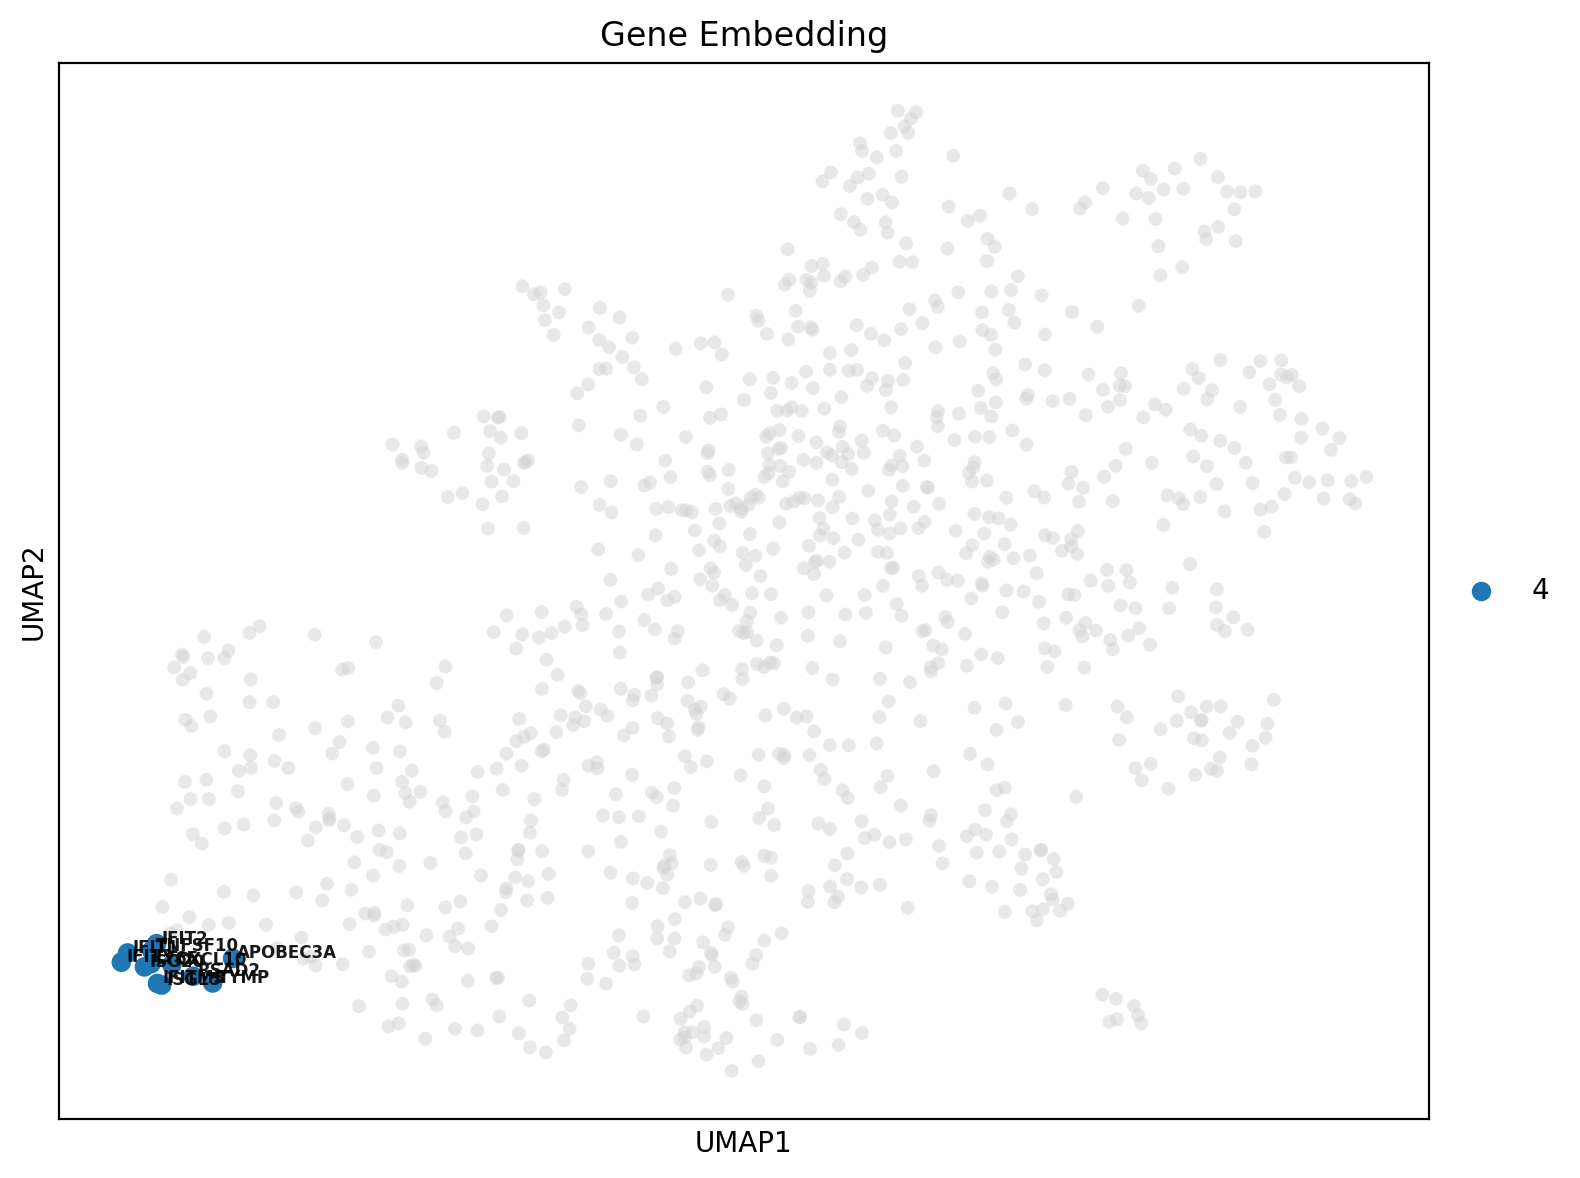

In [114]:
embed.plot_metagene(gdata, mg=isg_metagene)

In [116]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
embed.score_metagenes(adata, metagenes)

normalizing counts per cell
    finished (0:00:00)
computing score '21_SCORE'
    finished: added
    '21_SCORE', score of gene set (adata.obs).
    243 total control genes are used. (0:00:00)
computing score '4_SCORE'
    finished: added
    '4_SCORE', score of gene set (adata.obs).
    65 total control genes are used. (0:00:00)
computing score '79_SCORE'
    finished: added
    '79_SCORE', score of gene set (adata.obs).
    205 total control genes are used. (0:00:00)
computing score '48_SCORE'
    finished: added
    '48_SCORE', score of gene set (adata.obs).
    203 total control genes are used. (0:00:00)
computing score '188_SCORE'
    finished: added
    '188_SCORE', score of gene set (adata.obs).
    82 total control genes are used. (0:00:00)
computing score '131_SCORE'
    finished: added
    '131_SCORE', score of gene set (adata.obs).
    80 total control genes are used. (0:00:00)
computing score '47_SCORE'
    finished: added
    '47_SCORE', score of gene set (adata.obs).
    

/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


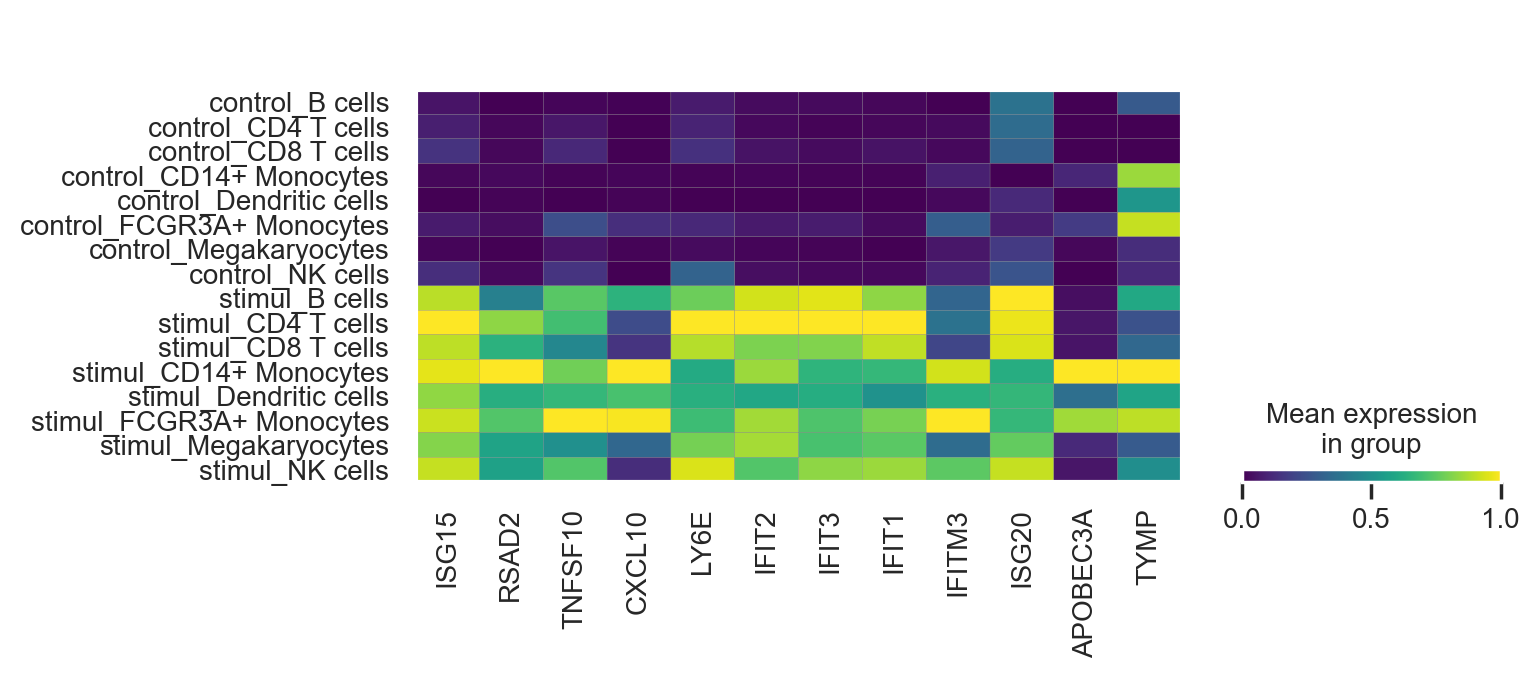

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.)
fig,ax = plt.subplots(1,1,figsize=(7,3))
sc.pl.matrixplot(adata,metagenes[isg_metagene],groupby="detailed_celltype",standard_scale="var",ax=ax)

# Plot All Metagenes

<Figure size 500x1300 with 0 Axes>

<Figure size 640x480 with 0 Axes>

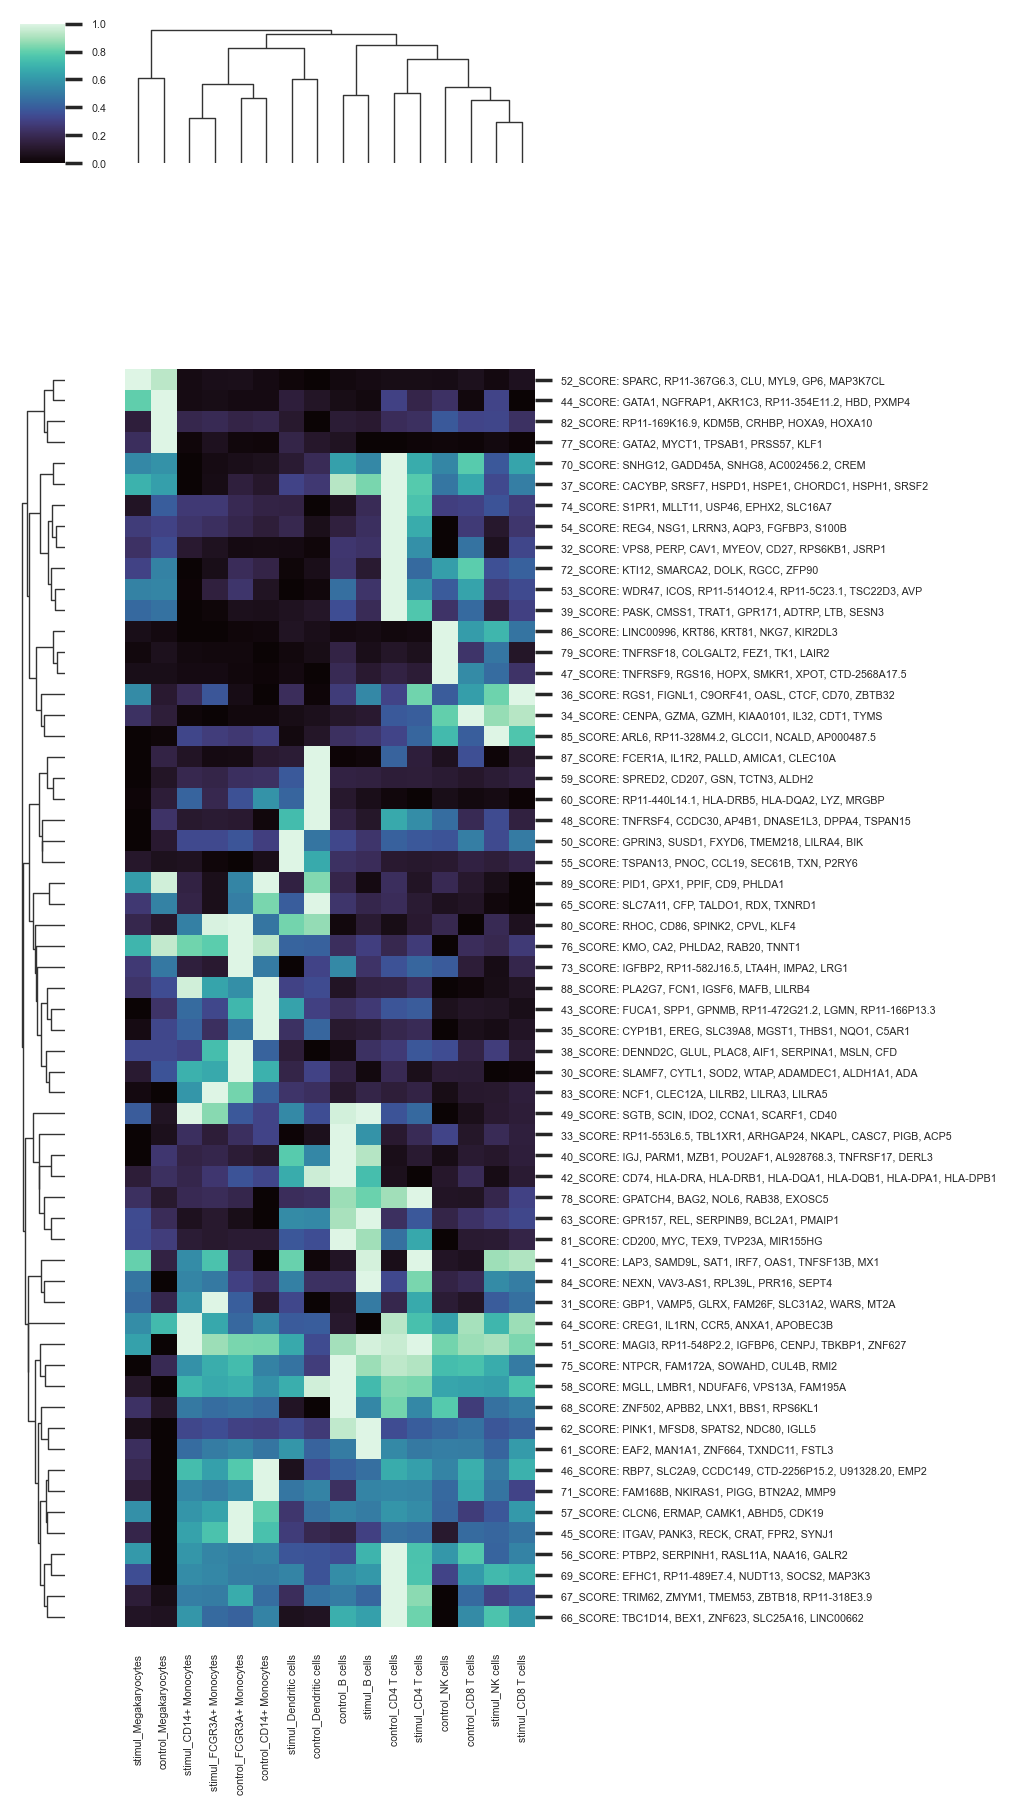

In [118]:
import numpy
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4 and len(genes) < 8:
        mgs[mg] = genes
sns.set(font_scale=0.35)
embed.plot_metagenes_scores(adata,mgs,"detailed_celltype")